In [120]:
#libraries
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import os
import seaborn as sns
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

from prophet import Prophet

pd.set_option("display.max_columns",None)
pd.set_option("display.width",500)
sns.set(rc={"figure.figsize":(12,12)}) 
color_pal = sns.color_palette()

In [121]:
response = pd.read_csv("./data/response.csv")
response.rename(columns = {'Timestamp_UTC':'Timestamp'}, inplace = True) 
features = pd.read_csv("./data/features.csv")

df = pd.merge(features, response, on='Timestamp')
df = df.set_index("Timestamp")
df.index= pd.to_datetime(df.index)


In [122]:
df.head(10)

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Timestamp,,,,,,,
2017-01-01 01:00:00,275.2,3.0,0.0,7.0,0.0,0.0,0.0
2017-01-01 02:00:00,275.4,9.0,0.0,8.0,0.0,0.0,0.0
2017-01-01 03:00:00,275.3,1.2,0.0,7.0,0.0,0.0,0.0
2017-01-01 04:00:00,275.1,9.5,0.0,8.0,0.0,0.0,0.0
2017-01-01 05:00:00,274.9,3.3,0.0,7.0,0.0,0.0,0.0
2017-01-01 06:00:00,274.3,7.3,0.0,8.0,0.0,0.0,0.0
2017-01-01 07:00:00,274.1,13.8,0.0,8.0,0.0,0.0,0.0
2017-01-01 08:00:00,273.8,0.4,0.0,7.0,0.0,0.0,0.0
2017-01-01 09:00:00,273.5,2.0,4.0,8.0,0.0,0.0,0.0


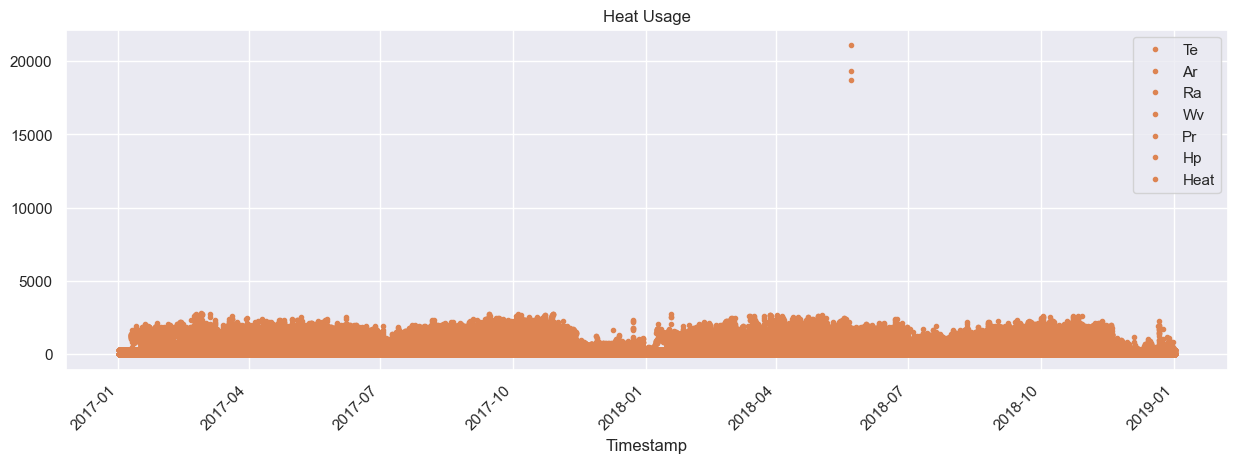

In [123]:
df.plot(style=".", figsize=(15,5), color= color_pal[1], title="Heat Usage")
plt.xticks(rotation = 45);

## Fill Missing Values

In [124]:
df.isnull().sum()

Te      2
Ar      0
Ra      0
Wv      0
Pr      0
Hp      0
Heat    2
dtype: int64

In [125]:
# https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/

def fill_nan_values(dataframe, feature):
    dataframe[feature]= dataframe[feature].interpolate(method='linear')

    return dataframe

df = fill_nan_values(df, "Heat")
df = fill_nan_values(df, "Te")


## Remove Outliers

In [126]:
print("Maximum heat:",df['Heat'].max()) # 21080.0
print("Average heat:",df['Heat'].mean()) # 1011.5
max_heat_index = df['Heat'].idxmax()
print("Index of maximum heat :",max_heat_index) # 12156
print("\n")
print(df.iloc[12145:12165]) # check the pattern

Maximum heat: 21080.0
Average heat: 1011.5537546062518
Index of maximum heat : 2018-05-22 14:00:00


                        Te    Ar     Ra   Wv   Pr      Hp          Heat
Timestamp                                                              
2018-05-22 03:00:00  288.6  13.0    0.0  2.0  1.4   813.2   1730.190132
2018-05-22 04:00:00  287.8   3.4    0.0  4.0  1.8   922.9   1661.370778
2018-05-22 05:00:00  287.1   5.2    0.0  6.0  0.4   979.3   1568.320909
2018-05-22 06:00:00  287.5   0.5    5.0  5.0  0.0  1064.7   1631.166978
2018-05-22 07:00:00  287.9   8.3   13.0  2.0  0.0   828.0   1166.835933
2018-05-22 08:00:00  289.1  10.8   31.0  2.0  0.0   678.4    650.955879
2018-05-22 09:00:00  292.2  12.1  101.0  4.0  0.0   478.9    273.993607
2018-05-22 10:00:00  294.1  14.2  158.0  2.0  0.0   261.8      0.000000
2018-05-22 11:00:00  295.7   0.7  259.0  3.0  0.0   165.7      0.000000
2018-05-22 12:00:00  292.2   1.4  337.0  4.0  0.0     0.0      0.000000
2018-05-22 13:00:00  291.8   7.4  2

In [127]:
def remove_outlier(dataframe,time_stamp):
    # identifying the timestamp to replace
    timestamp_to_replace = pd.to_datetime(time_stamp)

    # extracting the heats from the previous and next days
    previous_day_heat = dataframe[dataframe.index == (timestamp_to_replace - pd.DateOffset(days=1))]["Heat"].iloc[0]
    next_day_heat = dataframe[dataframe.index == (timestamp_to_replace + pd.DateOffset(days=1))]["Heat"].iloc[0]

    # replacing the heat value
    dataframe.loc[dataframe.index == timestamp_to_replace, "Heat"] = (previous_day_heat + next_day_heat) / 2

    return dataframe

In [128]:
df = remove_outlier(df,"2018-05-22 14:00:00")
df = remove_outlier(df,"2018-05-22 15:00:00")
df = remove_outlier(df,"2018-05-22 16:00:00")

print(df.iloc[12145:12165]) # check the pattern

                        Te    Ar     Ra   Wv   Pr      Hp         Heat
Timestamp                                                             
2018-05-22 03:00:00  288.6  13.0    0.0  2.0  1.4   813.2  1730.190132
2018-05-22 04:00:00  287.8   3.4    0.0  4.0  1.8   922.9  1661.370778
2018-05-22 05:00:00  287.1   5.2    0.0  6.0  0.4   979.3  1568.320909
2018-05-22 06:00:00  287.5   0.5    5.0  5.0  0.0  1064.7  1631.166978
2018-05-22 07:00:00  287.9   8.3   13.0  2.0  0.0   828.0  1166.835933
2018-05-22 08:00:00  289.1  10.8   31.0  2.0  0.0   678.4   650.955879
2018-05-22 09:00:00  292.2  12.1  101.0  4.0  0.0   478.9   273.993607
2018-05-22 10:00:00  294.1  14.2  158.0  2.0  0.0   261.8     0.000000
2018-05-22 11:00:00  295.7   0.7  259.0  3.0  0.0   165.7     0.000000
2018-05-22 12:00:00  292.2   1.4  337.0  4.0  0.0     0.0     0.000000
2018-05-22 13:00:00  291.8   7.4  287.0  6.0  0.0     0.0     0.000000
2018-05-22 14:00:00  291.9   8.8  296.0  7.0  0.0     0.0   442.078444
2018-0

In [129]:
split_date = '05-01-2018'
pjme_train = df.loc[df.index <= split_date].copy()
pjme_test = df.loc[df.index > split_date].copy()

In [130]:
pjme_test

,Te,Ar,Ra,Wv,Pr,Hp,Heat
Timestamp,,,,,,,
2018-05-01 01:00:00,279.1,2.0,0.0,21.0,2.4,983.9,1611.029815
2018-05-01 02:00:00,279.2,2.1,0.0,20.0,2.5,844.9,1674.381989
2018-05-01 03:00:00,279.4,8.4,0.0,20.0,1.7,770.1,1761.336659
2018-05-01 04:00:00,279.1,8.5,0.0,19.0,1.5,814.4,1760.679963
2018-05-01 05:00:00,279.1,12.6,0.0,17.0,1.8,890.2,1654.987638
...,...,...,...,...,...,...,...
2019-01-01 19:00:00,279.7,9.3,0.0,12.0,0.1,86.1,33.175193
2019-01-01 20:00:00,280.0,9.3,0.0,13.0,0.1,77.9,26.654784
2019-01-01 21:00:00,279.9,4.4,0.0,13.0,0.0,77.8,22.005693


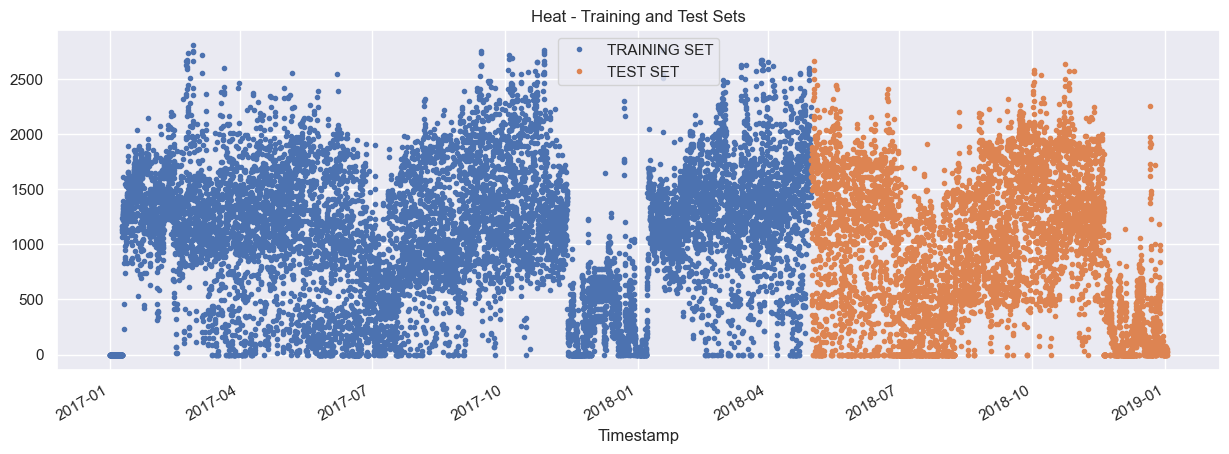

In [131]:
pjme_test \
    .rename(columns={'Heat': 'TEST SET'}) \
    .join(pjme_train.rename(columns={'Heat': 'TRAINING SET'}),
          how='outer', lsuffix='_test', rsuffix='_train') \
    [['TRAINING SET', 'TEST SET']] \
    .plot(figsize=(15, 5), title='Heat - Training and Test Sets', style='.')
plt.show()

## Simple Prophet Model

In [132]:
# Format data for prophet model using ds and y
pjme_train.reset_index() \
    .rename(columns={'Timestamp':'ds',
                     'Heat':'y'}).head()

,ds,Te,Ar,Ra,Wv,Pr,Hp,y
0,2017-01-01 01:00:00,275.2,3.0,0.0,7.0,0.0,0.0,0.0
1,2017-01-01 02:00:00,275.4,9.0,0.0,8.0,0.0,0.0,0.0
2,2017-01-01 03:00:00,275.3,1.2,0.0,7.0,0.0,0.0,0.0
3,2017-01-01 04:00:00,275.1,9.5,0.0,8.0,0.0,0.0,0.0
4,2017-01-01 05:00:00,274.9,3.3,0.0,7.0,0.0,0.0,0.0


In [133]:
# Setup and train model and fit
model = Prophet()
model.fit(pjme_train.reset_index() \
              .rename(columns={'Timestamp':'ds',
                     'Heat':'y'}))

00:50:19 - cmdstanpy - INFO - Chain [1] start processing
00:50:23 - cmdstanpy - INFO - Chain [1] done processing


In [134]:
# Predict on training set with model
pjme_test_fcst = model.predict(df=pjme_test.reset_index() \
                                   .rename(columns={'Timestamp':'ds'}))

In [135]:
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-05-01 01:00:00,1451.614837,1043.604277,2152.387693,1451.614837,1451.614837,124.659016,124.659016,124.659016,127.926793,127.926793,127.926793,-3.267777,-3.267777,-3.267777,0.0,0.0,0.0,1576.273853
1,2018-05-01 02:00:00,1451.742881,1128.421459,2208.890339,1451.742881,1451.742881,189.106281,189.106281,189.106281,194.386325,194.386325,194.386325,-5.280044,-5.280044,-5.280044,0.0,0.0,0.0,1640.849162
2,2018-05-01 03:00:00,1451.870925,1171.511776,2302.656571,1451.870925,1451.870925,291.930467,291.930467,291.930467,299.312698,299.312698,299.312698,-7.382231,-7.382231,-7.382231,0.0,0.0,0.0,1743.801391
3,2018-05-01 04:00:00,1451.998969,1291.229486,2415.483904,1451.998969,1451.998969,394.076762,394.076762,394.076762,403.628717,403.628717,403.628717,-9.551954,-9.551954,-9.551954,0.0,0.0,0.0,1846.075731
4,2018-05-01 05:00:00,1452.127012,1342.934874,2427.497096,1452.127012,1452.127012,437.416543,437.416543,437.416543,449.182617,449.182617,449.182617,-11.766075,-11.766075,-11.766075,0.0,0.0,0.0,1889.543555


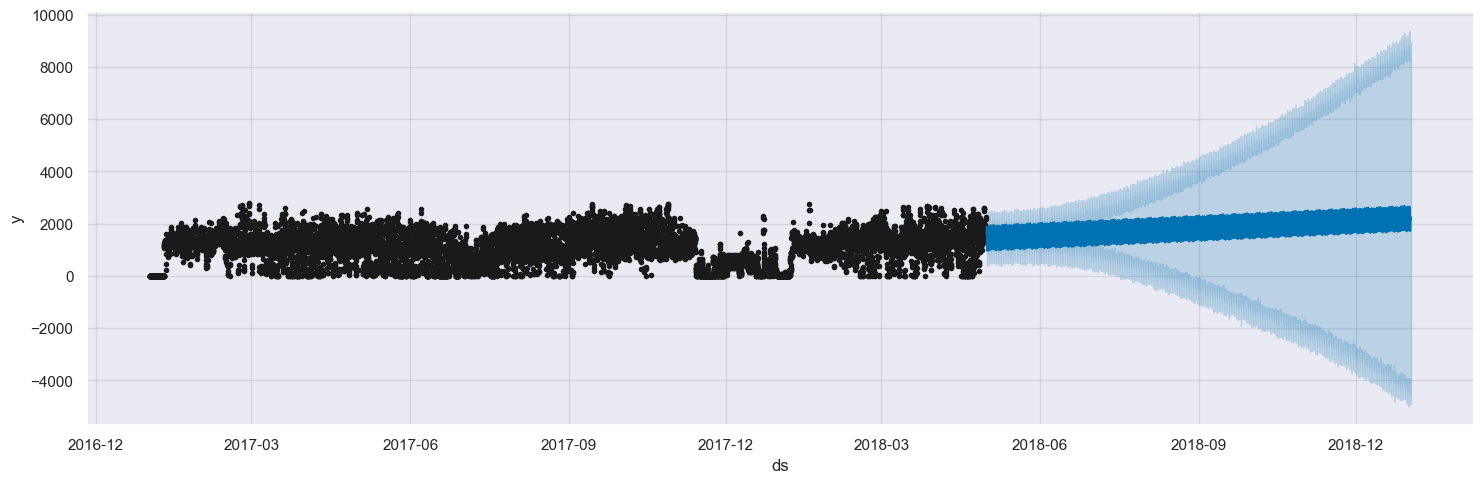

In [136]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(pjme_test_fcst,
                 ax=ax)
plt.show()

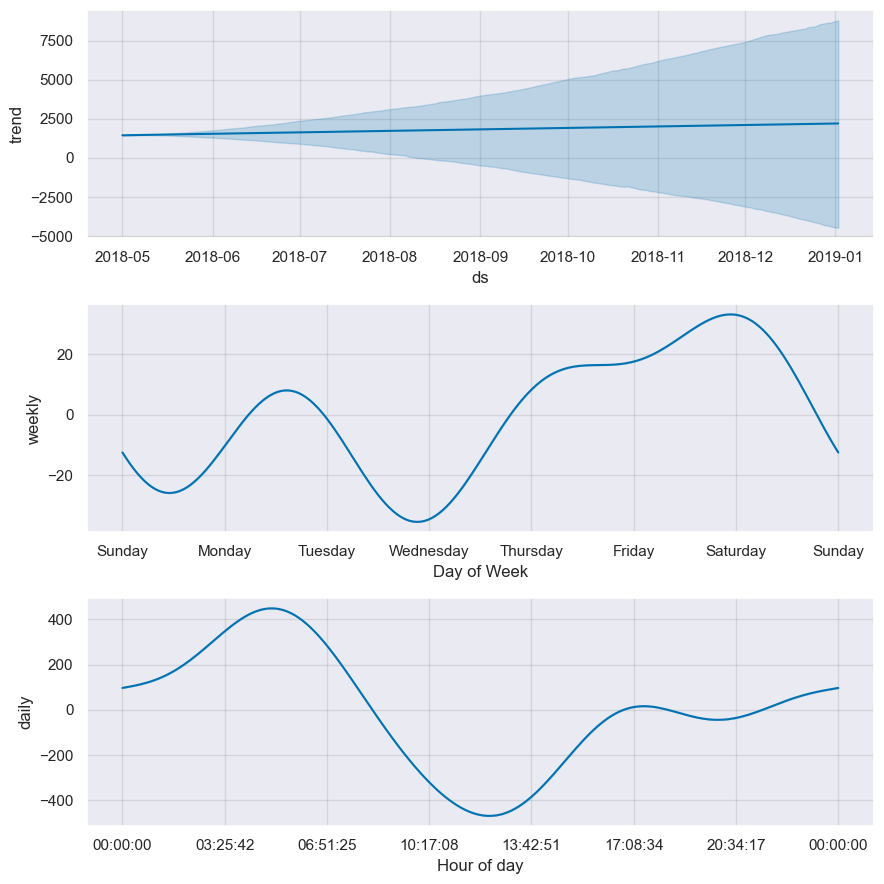

In [137]:
# Plot the components of the model
fig = model.plot_components(pjme_test_fcst)

## Compare Predicted to Actual

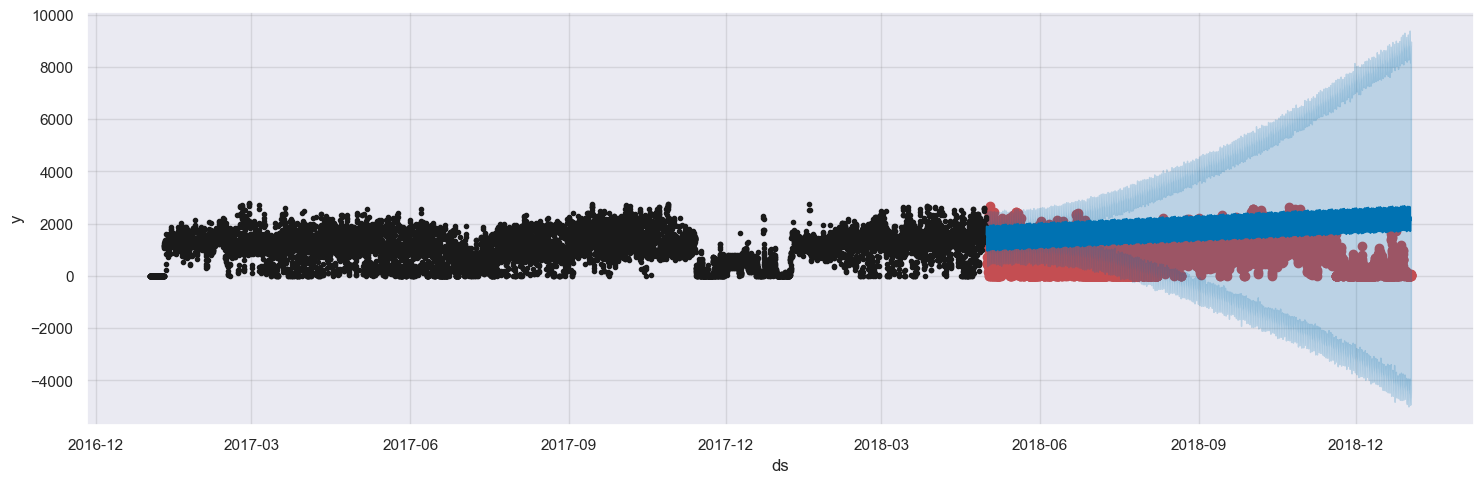

In [138]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Heat'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)

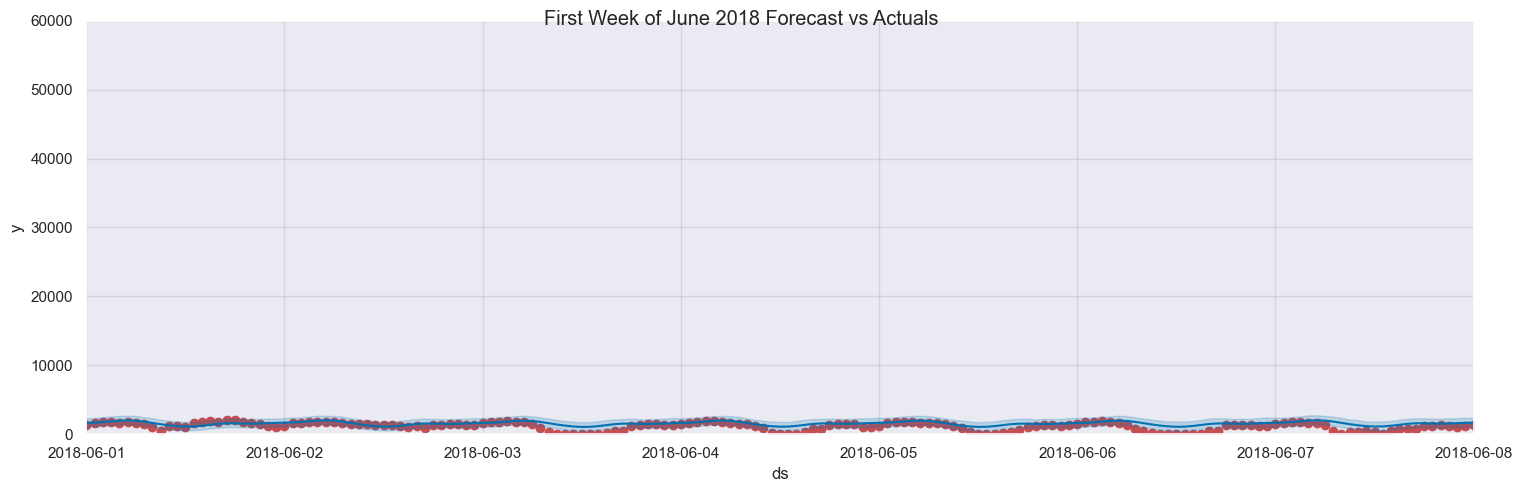

In [139]:
lower_bound = pd.to_datetime('2018-06-01')
upper_bound = pd.to_datetime('2018-06-08')

# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(pjme_test.index, pjme_test['Heat'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xlim(left=lower_bound, right=upper_bound)
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of June 2018 Forecast vs Actuals')
plt.show()

## Error Metrics

In [140]:
mean_squared_error(y_true=pjme_test['Heat'],
                   y_pred=pjme_test_fcst['yhat'])

1299877.429087985

In [141]:
mean_absolute_error(y_true=pjme_test['Heat'],
                   y_pred=pjme_test_fcst['yhat'])

959.2566244222613

## XGBOOST Model

## Train Test Split

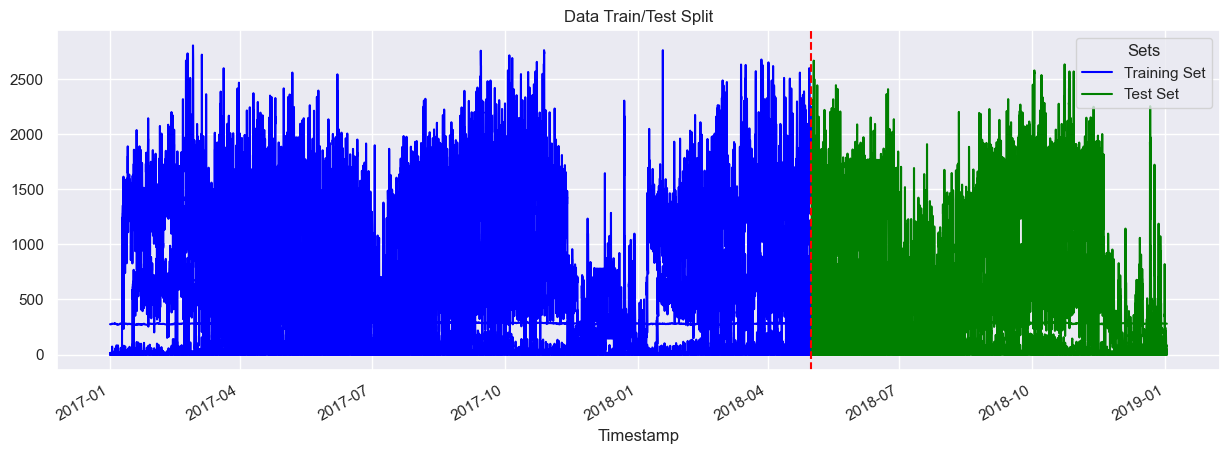

In [10]:
# train/test split
train = df.loc[df.index < '05-01-2018']
test = df.loc[df.index >= '05-01-2018']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label="Training Set", title="Data Train/Test Split", color="blue")
test.plot(ax=ax, label="Test Set", color="green")

# draw line to make the distribution clear
ax.axvline(pd.to_datetime('05-01-2018'), color='red', ls='--')
legend = ax.legend(labels=['Training Set', 'Test Set'], title='Sets', loc='upper right')
legend.legendHandles[0].set_color('blue')
legend.legendHandles[1].set_color('green')
plt.show()

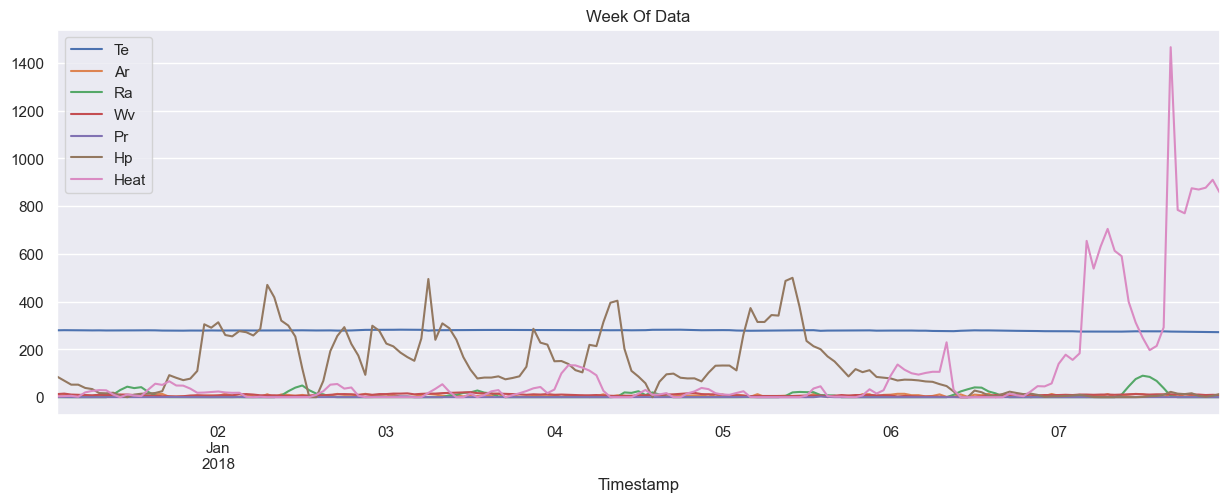

In [11]:
df.loc[(df.index > '01-01-2018') & (df.index < '01-08-2018')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

The <b>Te</b> quality remains relatively constant over time. The <b>HP</b> quality exhibits increases at consistent intervals throughout the day in the first five days, although this pattern is not observed on the 6th and 7th days. While <b>Heat</b> usage notably rises on the 7th day, the other days of the week display a similar trend, except for two distinct peaks.

In [12]:
# Feature Creation

def create_features(dataframe):
    """
    Create time series features based on time series index.
    """
    dataframe = dataframe.copy()
    dataframe['hour']= dataframe.index.hour
    dataframe['dayofweek']= dataframe.index.day_of_week
    dataframe['quarter']= dataframe.index.quarter
    dataframe['month']= dataframe.index.month
    dataframe['dayofyear']= dataframe.index.dayofyear

    return dataframe

df = create_features(df)

In [13]:
df.head(10)

,Te,Ar,Ra,Wv,Pr,Hp,Heat,hour,dayofweek,quarter,month,dayofyear
Timestamp,,,,,,,,,,,,
2017-01-01 01:00:00,275.2,3.0,0.0,7.0,0.0,0.0,0.0,1,6,1,1,1
2017-01-01 02:00:00,275.4,9.0,0.0,8.0,0.0,0.0,0.0,2,6,1,1,1
2017-01-01 03:00:00,275.3,1.2,0.0,7.0,0.0,0.0,0.0,3,6,1,1,1
2017-01-01 04:00:00,275.1,9.5,0.0,8.0,0.0,0.0,0.0,4,6,1,1,1
2017-01-01 05:00:00,274.9,3.3,0.0,7.0,0.0,0.0,0.0,5,6,1,1,1
2017-01-01 06:00:00,274.3,7.3,0.0,8.0,0.0,0.0,0.0,6,6,1,1,1
2017-01-01 07:00:00,274.1,13.8,0.0,8.0,0.0,0.0,0.0,7,6,1,1,1
2017-01-01 08:00:00,273.8,0.4,0.0,7.0,0.0,0.0,0.0,8,6,1,1,1
2017-01-01 09:00:00,273.5,2.0,4.0,8.0,0.0,0.0,0.0,9,6,1,1,1


In [14]:
duplicate_rows = df[df.duplicated(subset=df.columns.difference(['Timestamp']))]
print(duplicate_rows)


Empty DataFrame
Columns: [Te, Ar, Ra, Wv, Pr, Hp, Heat, hour, dayofweek, quarter, month, dayofyear]
Index: []


## Visualize Feature / Target Relationship

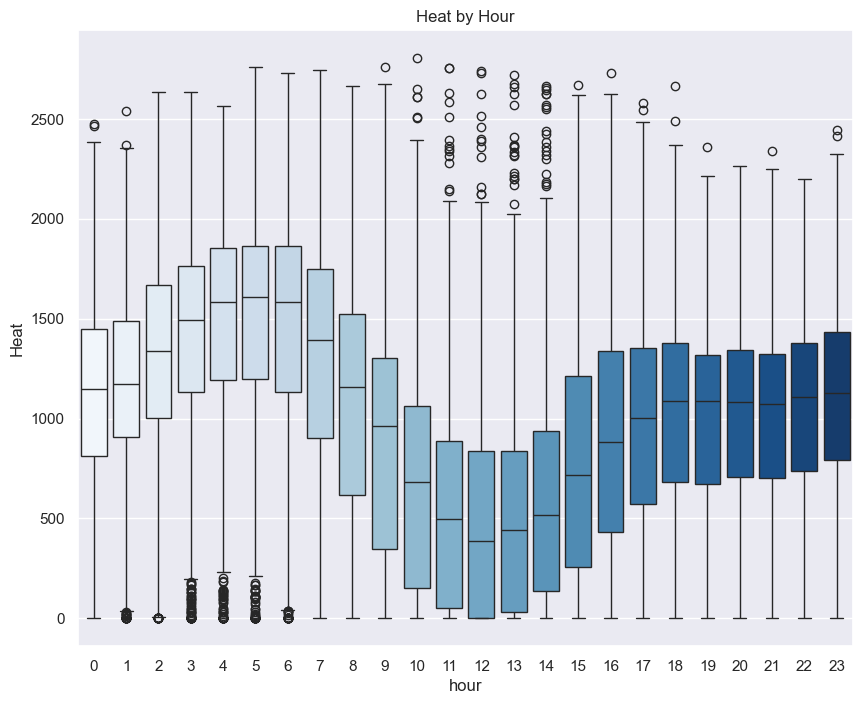

In [15]:
df_reset = df.reset_index()
# Plot the boxplot with the reset DataFrame
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_reset, x='hour', y='Heat', palette='Blues')
ax.set_title('Heat by Hour')
plt.show();

## Create the Model

In [16]:
train = create_features(train)
test = create_features(test)

FEATURES = ["Te", "Ar", "Ra", "Wv", "Pr", "Hp", "Heat", "hour", "dayofweek", "quarter", "month", "dayofyear"]
TARGET = "Heat"

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [17]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:1211.98647	validation_1-rmse:1095.11836
[100]	validation_0-rmse:447.18409	validation_1-rmse:402.66564
[200]	validation_0-rmse:165.39182	validation_1-rmse:148.24099
[300]	validation_0-rmse:61.47700	validation_1-rmse:54.93738
[400]	validation_0-rmse:23.38407	validation_1-rmse:20.81066
[500]	validation_0-rmse:10.10601	validation_1-rmse:8.73703
[600]	validation_0-rmse:6.20463	validation_1-rmse:5.10008
[700]	validation_0-rmse:5.36896	validation_1-rmse:4.31245
[800]	validation_0-rmse:5.10560	validation_1-rmse:4.15948
[900]	validation_0-rmse:5.03764	validation_1-rmse:4.12621
[991]	validation_0-rmse:4.92874	validation_1-rmse:4.13197


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

## Feature Importance

In [18]:
feature_importance = pd.DataFrame(data=reg.feature_importances_, index=reg.feature_names_in_, columns=['importance'])

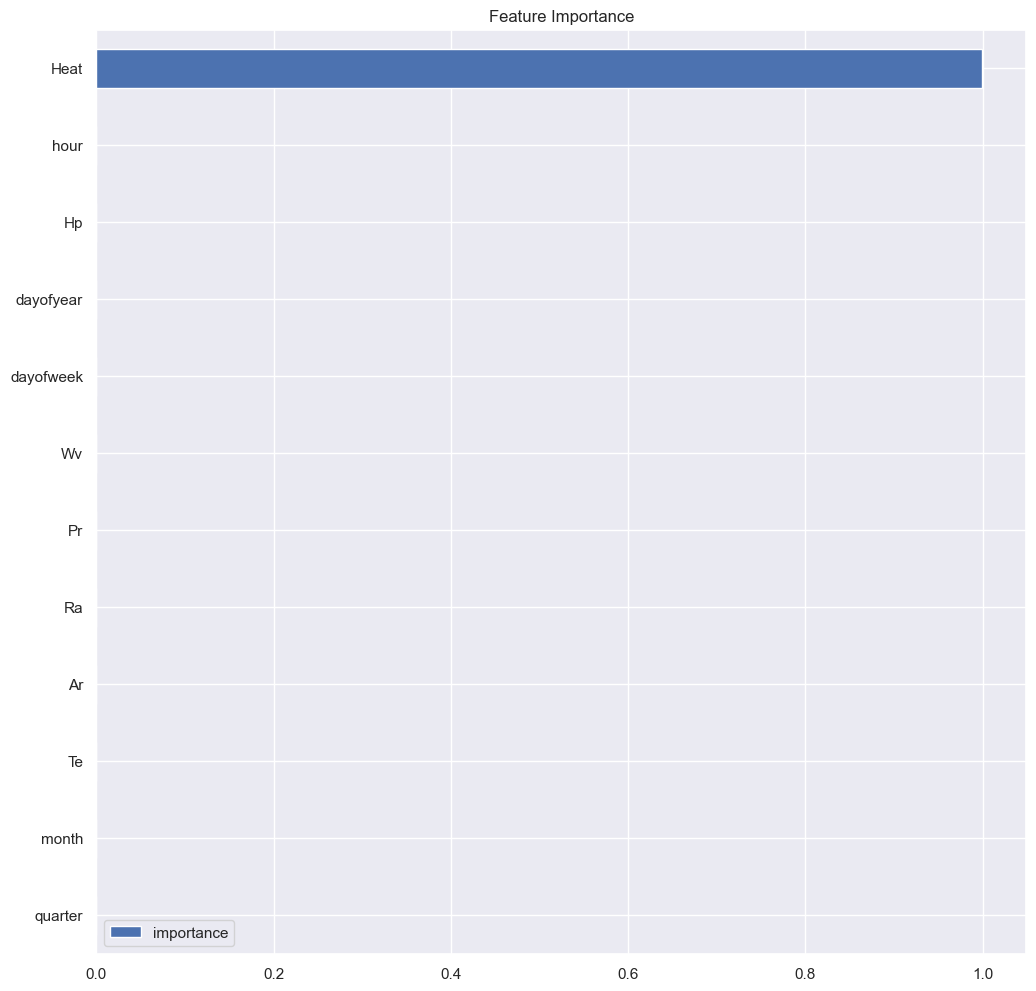

In [19]:
feature_importance.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

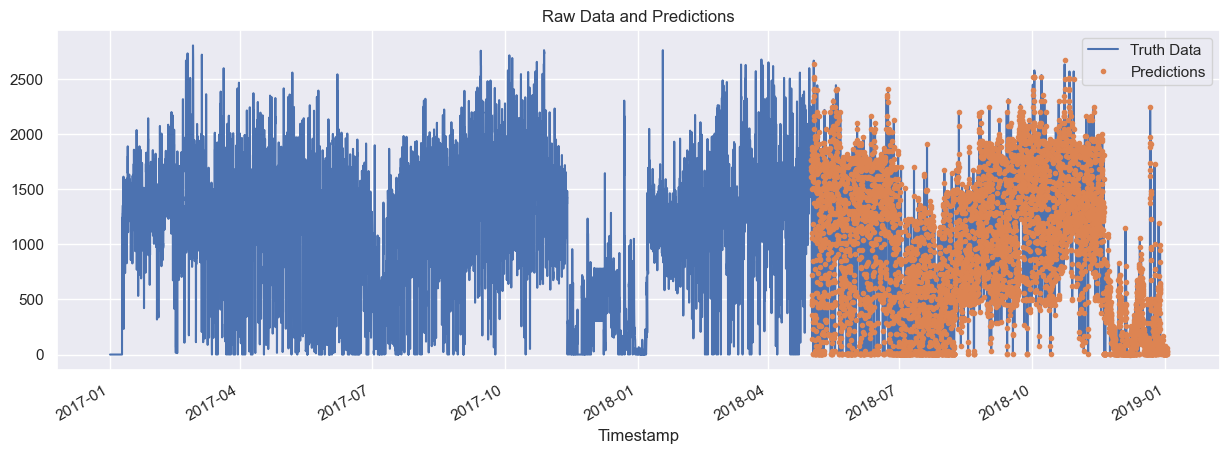

In [20]:
test['prediction'] = reg.predict(X_test)

# merging based on the index
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
#df = df.drop(['prediction_x', 'prediction_y'], axis=1)

ax = df[['Heat']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

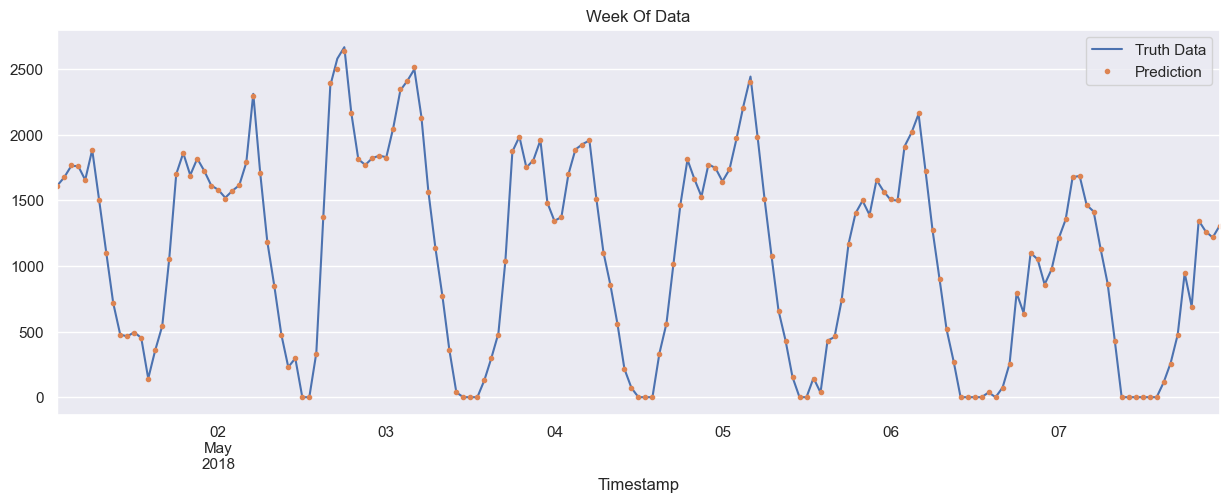

In [21]:
ax = df.loc[(df.index > '05-01-2018') & (df.index < '05-08-2018')]['Heat'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '05-01-2018') & (df.index < '05-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

## Evaluating

In [22]:
score = np.sqrt(mean_squared_error(test['Heat'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 4.12


In [23]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10) # average error of the each day predicted

date
2018-10-02    9.563467
2018-10-26    8.392054
2018-05-02    7.838832
2018-10-01    7.393673
2018-05-18    6.414235
2018-09-22    5.922155
2018-10-23    4.759843
2018-10-29    4.493526
2018-05-05    4.416901
2018-10-07    4.223734
Name: error, dtype: float64